In [35]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [36]:
path = os.path.join("train.csv","train.csv")
df = pd.read_csv(path)

In [37]:

df.columns = df.columns.str.strip() # Leading and trailing

In [38]:
df.head(7)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0


In [39]:
from tensorflow.keras.layers import TextVectorization

In [40]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [41]:
max_words = 200000

In [42]:
vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=1800, output_mode='int')

In [43]:
vectorizer.adapt(X.values)

In [44]:
vectorizer("I am the best")[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([  8,  74,   2, 217], dtype=int64)>

In [45]:
vectorized_text = vectorizer(X.values)

In [46]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [47]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [48]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [49]:
train_generator = train.as_numpy_iterator()

In [50]:
train_generator.next()

(array([[    8,    19,  2274, ...,     0,     0,     0],
        [  433,  9811,   118, ...,     0,     0,     0],
        [    8,   210, 94234, ...,     0,     0,     0],
        ...,
        [    7,   119,     3, ...,     0,     0,     0],
        [   14,    39,    17, ...,     0,     0,     0],
        [  242,  4733, 15899, ...,     0,     0,     0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

MODEL CREATION

In [51]:
# LSTM has feedback connections. Such a recurrent neural network (RNN) can process not only single data points (such as images), but also entire sequences of data (such as speech or video). This characteristic makes LSTM networks ideal for processing and predicting data.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional

In [52]:
model = Sequential()
model.add(Embedding(max_words+1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))

model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))

model.add(Dense(6, activation = 'sigmoid'))

In [53]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [55]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 7002s 1s/step - loss: 0.0626 - val_loss: 0.0454


In [56]:
from matplotlib import pyplot as plt

In [57]:
history.history

{'loss': [0.06263139843940735], 'val_loss': [0.045442044734954834]}

<Figure size 640x480 with 0 Axes>

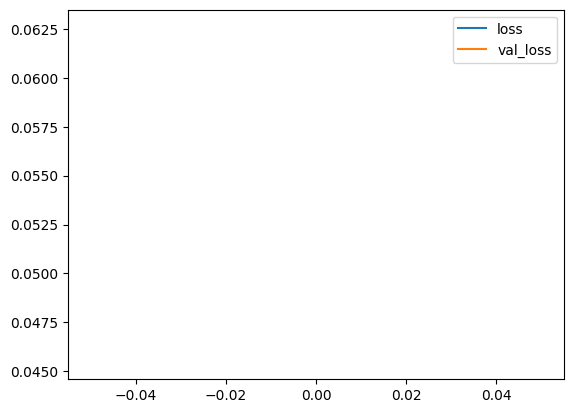

In [58]:
plt.figure()
pd.DataFrame(history.history).plot()
plt.show()

MAKING PREDICTIONS

In [59]:
input_text = vectorizer('I hate you! I am goig to kill you nigga!')

In [60]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([  8, 363,   7, ...,   0,   0,   0], dtype=int64)>

In [61]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [62]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


array([[0.9804119 , 0.0875769 , 0.8518987 , 0.01821654, 0.66806626,
        0.11201536]], dtype=float32)

In [63]:
batch_X,batch_y = test.as_numpy_iterator().next()

In [64]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [65]:
(model.predict(batch_X)>0.5).astype(int)

1/1 [==============================] - 0s 171ms/step


array([[0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [66]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [67]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [68]:
for batch in test.as_numpy_iterator():
    #unpack the batch
    X_true, y_true = batch
    #make predictions
    yhat = model.predict(X_true)
    #flatten the true and predicted labels
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 174ms/step


In [69]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8170501589775085, Recall: 0.6485030055046082, Accuracy: 0.4663991928100586


In [70]:
#model.save('toxic.h5')

In [2]:
import tensorflow as tf
import gradio as gr
import joblib

d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
filename = "Completed_model.joblib"
joblib.dump(model, filename)

['Completed_model.joblib']

In [3]:
model_load = joblib.load("Completed_model.joblib")

In [4]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model_load.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [5]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [6]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://6d71e5b98c6730a55a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\gradio\routes.py", line 401, in run_predict
    output = await app.get_blocks().process_api(
  File "d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\gradio\blocks.py", line 1302, in process_api
    result = await self.call_function(
  File "d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\gradio\blocks.py", line 1025, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "d:\Python_Codes\Pandas\Projects\Amazon Love\amazon\.conda\lib\site-pac

In [7]:
!pip install gardio jinja2

ERROR: Could not find a version that satisfies the requirement gardio (from versions: none)
ERROR: No matching distribution found for gardio
